# ZTF Big Data Clusters / Spark Demo

For demo and evaluation purposes, IDIES has obtained > 3TB dataset of ZTF data containing over a billion lightcurves, which is loaded into one of our evaluation Spark clusters, in an HDFS store of parquet files. Using Jupyter notebooks on SciServer configured with [sparkmagic](https://github.com/jupyter-incubator/sparkmagic), we can query and do analysis on this large dataset in realtime.

## Setup session
The notebook does not automatically get a session on startup, so we configure one at the beginning of the notebook (the defaults result in a rather small number of total cores). In our evaluation systems, each session is permitted to allocate the entire cluster and there are no reservations. In a production system, we would be implementing reservations and/or jobs or such mechanisms.

In this demo, we get 224 (28 executors x 8 cores each) cores and a total and 336GB of memory (28 executors x 12GB each):

In [1]:
%%configure -f 
{ "numExecutors": 60, "executorCores": 7, "executorMemory": "12gb" }

In [2]:
import matplotlib.pyplot as plt
import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1641311088831_0015,pyspark,idle,Link,Link,arik,✔


SparkSession available as 'spark'.


A timer for evaluation

In [3]:
import time
class timer():
    def __init__(self):
        self.time = None
    def __enter__(self):
        self.time = time.time()
    def __exit__(self, type, value, tb):
        print('Wall time: {:.4f}'.format(time.time() - self.time))

## Setup dataset and session-scoped SQL tables

Spark does computations in a lazy fashion, so we don't really "read" the data, but rather define the datasets we will use to run SQL queries or other computations on. We do this by reading into a spark DataFrame, and then defining a name for that dataframe when sending SQL statements.

In [4]:
HDFS_DEST = '/data/ztf/ztf_dr3'
ztf = spark.read.parquet('hdfs://' + HDFS_DEST)

In [5]:
ztf.createOrReplaceTempView('ztf')

Parquet tables can contain compound types like arrays and structs. For the ZTF data, each row is an object, and there are columns for lightcurve (**mjd_{band}**, **mag_{band}**), which each contain a variable number of datapoints in an array format. This format is quite natural for running arbitrary python code, but slightly more cumbersome for pure SQL - though there are functions that assist in working with these types.

In [6]:
ztf.printSchema()

root
 |-- ps1_objid: long (nullable = true)
 |-- ra: double (nullable = true)
 |-- dec: double (nullable = true)
 |-- mean_mag_g: double (nullable = true)
 |-- mean_mag_r: double (nullable = true)
 |-- mean_mag_i: double (nullable = true)
 |-- ra_stddev: double (nullable = true)
 |-- dec_stddev: double (nullable = true)
 |-- ps1_gMeanPSFMag: double (nullable = true)
 |-- ps1_rMeanPSFMag: double (nullable = true)
 |-- ps1_iMeanPSFMag: double (nullable = true)
 |-- ra_detections: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- dec_detections: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- mjd_g: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- mag_g: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- magerr_g: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- psfflux_g: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- psfflux

## Query Evaluations

### Row Counts
Straight count of rows, as the parquet format contains metadata (including row counts), we only need to read a small amount of data here (but from a large number of files)

In [7]:
with timer():
    ztf.count()

1187012476
Wall time: 32.1037

This large dataset has lots of partitions, as we can see below. There are about 500 files, each partition is actually a single block from the underlying HDFS filesystem which can be read in one shot by a single executor - this size of blocks here is max 128MB each.

In [8]:
ztf.rdd.getNumPartitions()

27369

Just a tuning parameter. The default of 200 shuffle partitions might be too low, here we expand that to 800 (which by experiment does appear to speed of queries that require shuffling data.

In [9]:
spark.conf.set("spark.sql.shuffle.partitions", "800")

While in principal each of the rows here should be a unique object with its lightcurve represented as array type columns. Let's check that by comparing the number of unique object ids with the rows we found above. Indeed we find that there are a number of duplicates, accounding for \~100M objects (or <\~10%)

In [ ]:
with timer():
    spark.sql('''SELECT count(distinct(ps1_objid)) FROM ztf''').show()

### Sky Coverage
What is the sky coverage like? With ~1.2B points, this kind of plot must be binned up and plotted as a density histogram. To keep things simple, we just bin by integer degrees and get observation and object counts within those bins

In [ ]:
with timer():
    nobs_radec = spark.sql('''
    SELECT ra, dec, avg(nobs_g) AS nobs, count(distinct(ps1_objid)) AS nobj FROM 
     (SELECT CAST(ra as INT) ra, CAST(dec as INT) dec, nobs_g, ps1_objid FROM ztf)
    GROUP BY ra, dec
    ''').toPandas()
    nobs_radec.head()

In [ ]:
f, a = plt.subplots(1, 2, figsize=(12,4))
plt.sca(a[0])
plt.hexbin(nobs_radec['ra'], nobs_radec['dec'], nobs_radec['nobj'], bins='log', reduce_C_function=sum)
plt.colorbar()
plt.title('N objects total')
plt.ylabel('dec')
plt.xlabel('ra')
plt.sca(a[1])
plt.hexbin(nobs_radec['ra'], nobs_radec['dec'], nobs_radec['nobs'], bins='log', reduce_C_function=sum)
plt.colorbar()
plt.title('N observations avg')
plt.xlabel('ra')
plt.subplots_adjust(left=0.05, right=0.98, wspace=0.1)

In [ ]:
%matplot plt

### Inspecting Lightcurves
What does a lightcurve in this dataset look like?

In [ ]:
with timer():
    exs = spark.sql('''SELECT * FROM ztf WHERE nobs_g > 100 AND nobs_i > 0 AND nobs_r > 0''').take(10)

In [ ]:
len(exs)

In [ ]:
import numpy as np
f, a = plt.subplots(4, 1, figsize=[12,6])
for i in range(4):
    plt.sca(a[i])
    ex = exs[i]
    for c in ['g', 'r', 'i']:
        idx = np.argsort(ex['mjd_'+c])
        x = np.array(ex['mjd_'+c])[idx]
        y = np.array(ex['mag_'+c])[idx]
        y_e = np.array(ex['magerr_'+c])[idx]
        color = c if c != 'i' else 'b'
        _ = plt.errorbar(x, y, yerr=y_e, c=color, marker='_', ls='')

In [ ]:
%matplot plt

### More in-depth analysis using Python - find "dippy" objects

We can run arbitray python functions that operate on each row in the distributed DataFrame. This is really useful when you want to run such functions on an entire dataset *prior* to filtering or aggregating (e.g. you filter on the results of the calculation), and logic is difficult or impossible to express in SQL statements using the built in functions.

These functions can either be run via an SQL UDF, or via the lower-level spark RDD interface to the dataframe, which we use in the example below, which makes a basic attempt at identifying those lightcurves in the G band that exhibit significant spikiness dipping below the "quiescent" level of the lightcurve. We seek such objects across the entire dataset of 1B+ lightcurves, requiring computation of the quiescent level and dippiness for each object prior to filtering.

In [21]:
Q_NSIG = 3
def find_quiescent(mag, nsig=Q_NSIG):
    data = np.array(mag)
    mask = np.arange(len(data))
    while True:
        mean = data[mask].mean()
        thresh = nsig * data[mask].std()
        mask_ = np.where(np.abs(data[mask] - mean) <= thresh)[0]
        if mask_.size == 0 or mask_.size == mask.size:
            break
        mask = mask[mask_]
    return (mean, data, mask)

D_NSIG, D_RATE = 10, 0.2
def with_dips(data, nsig=D_NSIG, rate=D_RATE):
    mean, data, mask = data
    masked = data[mask]
    diffs = data - mean
    thresh = nsig * masked.std()
    dips = np.where(diffs > thresh)[0]
    if dips.size > rate * data.size:
        return True
    return False

In [38]:
with timer():
    q = spark.sql('''SELECT mag_g FROM ztf WHERE nobs_g > 100''').rdd.map(lambda r: find_quiescent(r.mag_g)).filter(with_dips)
    q.count()
    test = q.take(10)

42
Wall time: 298.1201

42 such objects identified from within 1B (in ~5 minutes!), making them exceedingly rare. Of course we have insisted on a relatively high number of epochs. Given the relatively small time commitment, these analyses can be iterated and tuned in a real-time-discovery like fashion

In [39]:
plt.close()
f, a = plt.subplots(3, 2, figsize=[14,6])
a = list(a.ravel())
for i in range(len(a)):
    tmn, td, tm = test[i]
    ts = tmn - td
    lp = np.where(td - tmn > D_NSIG*td[tm].std())[0]
    plt.sca(a.pop())
    _ = plt.plot(ts, marker='_', ls='--', c='k')
    _ = plt.plot(tm, ts[tm], marker='s', mfc='none', ls='', c='blue')
    _ = plt.plot(lp, ts[lp], marker='o', mfc='none', ls='', c='red')
plt.tight_layout()

HttpClientException: Invalid status code '404' from https://apps.sciserver.org/sparkgw/dracula/livy/sessions/7 with error payload: {"timestamp":"2021-12-22T15:59:59.397+0000","status":404,"error":"Not Found","message":"404 Not Found from GET http://livy:8998/sessions/7","path":"/livy/sessions/7"}

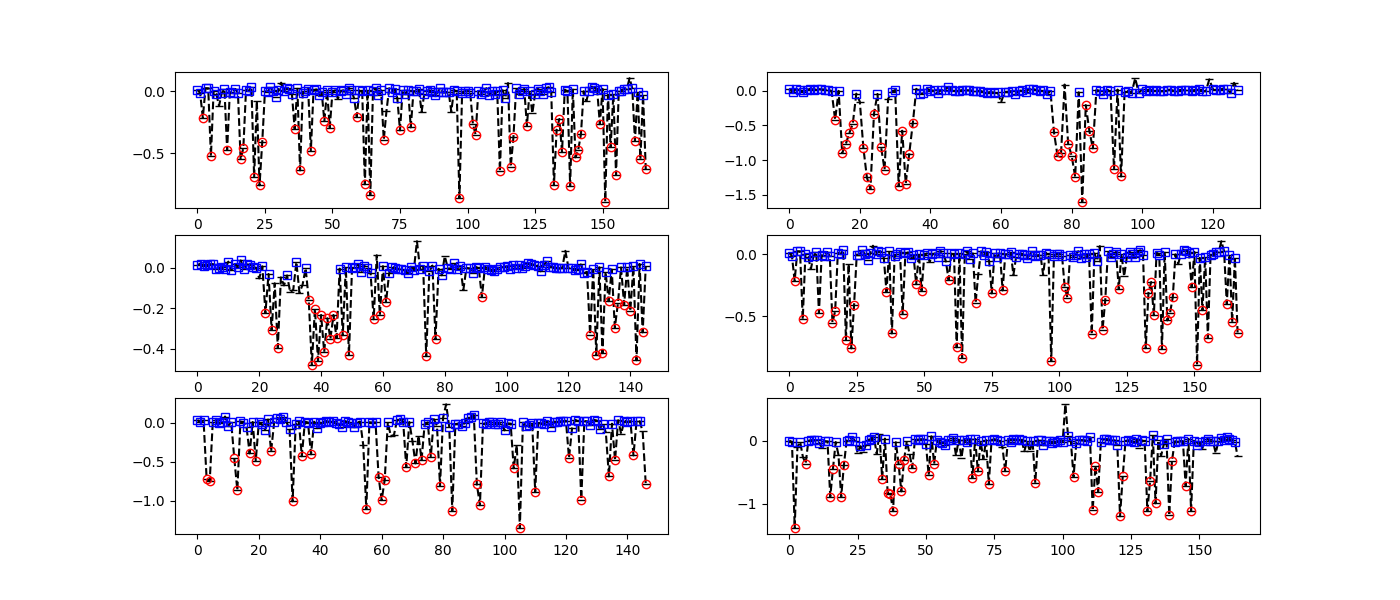

In [37]:
%matplot plt

### Get some weird stuff

The search above identifies lightcurves (in G-band) which are "spiky", or "dippy". Lets try to find those that are more patterned or sinusoidal. For such lightcurves, most points will actually be away from the mean, so we can define a function that returns a measure of "away-from-meanness", or antiaffinity. To prevent this from getting spiky stuff, we can attenuate the points further from the mean by taking the square root of the difference (we are looking more for the number of points, and not the overall difference).

As it turns out, while the search does return objects that ostensibly meet expectations, it also returns some really bonkers looking stuff, likely errors in the analysis or QA pipelines or issues with observations like CCD problems or bad conditions, neighboring bright objects etc. These are fun to look at in any case!

In [ ]:
def mean_antiaffinity(data):
    mean, data, mask = data
    d = np.sqrt(abs(data - mean)).sum()
    return d

In [ ]:
with timer():
    q = spark.sql('''SELECT mag_g FROM ztf WHERE nobs_g > 100''').rdd.map(
        lambda r: find_quiescent(r.mag_g)
    ).map(
        lambda x: x + (mean_antiaffinity(x),)
    ).filter(
        lambda x: x[-1] > 200
    )
    res = q.take(100)

A **note** about the above query: the spark engine will try it's best to minimize the work it needs to do, so it will only read in enough partitions to satisfy the number of items requsted in take. It starts with a single partition, and expands this till satisfied. Sorting and taking the absolute highest values is a significantly heavier operation, so I have experimented to arrive at the filter threshold above, iterating on small queries like this taking a few seconds each.

In [ ]:
res = sorted(res, key=lambda x: -1*x[-1])

In [ ]:
plt.clf()
f, a = plt.subplots(5, 3, figsize=(16,8))
a = list(np.ravel(a))
for i in range(len(a)):
    plt.sca(a.pop())
    _ = plt.axhline(res[i][0], c='k')
    _ = plt.plot(res[i][1], c='silver')

The plots below show the computed "quiescent" mean as a horizontal black line, with the g-band lightcurve in grey. The values are plotted sequentially, and gaps in time are not shown.

In [ ]:
%matplot plt